### **Model Development**

After conducting a thorough exploratory data analysis in the previous step, we have gained valuable insights into the credit card fraud detection dataset. This analysis has helped us understand the factors contributing to fraudulent transactions and identify patterns that can aid in fraud detection.

In this phase, we aim to develop a predictive model for credit card fraud detection. The goal is to empower merchants with the ability to identify and predict fraudulent transactions, thereby minimizing business losses and enhancing operational efficiency.

The objectives for the model development are:

- Build a robust classification model to accurately predict fraudulent transactions.

- Prioritize the F1 Score as the primary evaluation metric, focusing on the minority class due to the imbalanced nature of the dataset. 

---

### **Project Setup**

In [104]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer

# Training and Evaluations
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, average_precision_score
from sklearn.metrics import recall_score, precision_score, f1_score, make_scorer

# Hyper-parameter Tuning and Cross Validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Import machine learning models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
import joblib

In [16]:
# Read the dataset
df = pd.read_csv("credit_card_fraud.csv")
df.head()

,transaction_time,credit_card_number,merchant,category,transaction_amount,gender,street,city,state,zip,city_population,job,transaction_number,is_fraud,full_name,age,transaction_location,merchant_location,transaction_hour,is_nighttime,distance_km
0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,3495,"Psychologist, counselling",0b242abb623afc578575680df30655b9,0,Jennifer Banks,31,"-81.1781, 36.0788","-82.048315, 36.011293",0,1,78.597568
1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,149,Special educational needs teacher,1f76529f8574734946361c461b024d99,0,Stephanie Gill,41,"-118.2105, 48.8878","-118.186462, 49.159046999999994",0,1,30.212176
2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,4154,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,0,Edward Sanchez,57,"-112.262, 42.1808","-112.154481, 43.150704",0,1,108.206083
3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,1939,Patent attorney,6b849c168bdad6f867558c3793159a81,0,Jeremy White,52,"-112.1138, 46.2306","-112.561071, 47.034331",0,1,95.673231
4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,M,408 Bradley Rest,Doe Hill,VA,24433,99,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,0,Tyler Garcia,33,"-79.4629, 38.4207","-78.632459, 38.674999",0,1,77.556744


In [17]:
# Dataset information 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   transaction_time      object 
 1   credit_card_number    int64  
 2   merchant              object 
 3   category              object 
 4   transaction_amount    float64
 5   gender                object 
 6   street                object 
 7   city                  object 
 8   state                 object 
 9   zip                   int64  
 10  city_population       int64  
 11  job                   object 
 12  transaction_number    object 
 13  is_fraud              int64  
 14  full_name             object 
 15  age                   int64  
 16  transaction_location  object 
 17  merchant_location     object 
 18  transaction_hour      int64  
 19  is_nighttime          int64  
 20  distance_km           float64
dtypes: float64(2), int64(7), object(12)
memory usage: 296.8+ MB


In [18]:
# Change data types
df["transaction_time"] = pd.to_datetime(df["transaction_time"])
df["credit_card_number"] = df["credit_card_number"].astype(str)
df["zip"] = df["zip"].astype(str)
df["is_fraud"] = df["is_fraud"].astype(str)
df["is_nighttime"] = df["is_nighttime"].astype(str)

In [19]:
# Descriptive statistics on numerical features
df.describe().T

,count,mean,min,25%,50%,75%,max,std
transaction_time,1852394,2020-01-20 21:31:46.801827328,2019-01-01 00:00:18,2019-07-23 04:13:43.750000128,2020-01-02 01:15:31,2020-07-23 12:11:25.249999872,2020-12-31 23:59:34,NaN
transaction_amount,1852394.0,70.063567,1.0,9.64,47.45,83.1,28948.9,159.253975
city_population,1852394.0,88643.674509,23.0,741.0,2443.0,20328.0,2906700.0,301487.618344
age,1852394.0,46.21138,14.0,33.0,44.0,57.0,96.0,17.395446
transaction_hour,1852394.0,12.806119,0.0,7.0,14.0,19.0,23.0,6.815753
distance_km,1852394.0,76.111726,0.022255,55.320087,78.21638,98.509467,152.117173,29.11697


In [20]:
# Descriptive statistics on categorical features
df.describe(include='object').T

,count,unique,top,freq
credit_card_number,1852394,999,6538441737335434,4392
merchant,1852394,693,Kilback LLC,6262
category,1852394,14,gas_transport,188029
gender,1852394,2,F,1014749
street,1852394,999,444 Robert Mews,4392
city,1852394,906,Birmingham,8040
state,1852394,51,TX,135269
zip,1852394,985,82514,5116
job,1852394,497,Film/video editor,13898
transaction_number,1852394,1852394,0b242abb623afc578575680df30655b9,1


**Dataset Description**: This dataset was intially used inside the notebook file for exploratory data analysis to understand and gain more insights of fraud transactions. There were some cleaning and new columns added and now we will use this dataset to do preprocessing before fitting into the models.

---

### **Data Preprocessing**

In this crucial step, we establish a robust preprocessing pipeline to transform raw transaction data into optimized features for our fraud detection models. Our preprocessing strategy addresses the unique challenges of credit card fraud detection:

Pipeline Components

**1. Feature Engineering & Transformation**

- Apply column-specific transformations using ColumnTransformer

- Encode categorical variables using OneHotEncoder to properly represent merchant categories and transaction types

**2. Dimensionality Reduction**

- Implement feature selection using SelectFromModel with a Random Forest estimator

- Target the most predictive features based on importance thresholds

- Reduce noise while preserving signal in high-dimensional transaction data

**3. Class Imbalance Handling**

- Address the severe imbalance (0.52% fraud cases) using SMOTE

- Generate synthetic minority samples in the training data only

- Maintain controlled sampling ratio of 1:10 to prevent overfitting

**4. Pipeline Integration**

- Ensure consistent application of transformations across training and testing data

- Prevent data leakage by fitting preprocessing steps only on training data

- Use imblearn.Pipeline to seamlessly integrate preprocessing and sampling

In [21]:
# Get only necessary columns
features = ["transaction_amount", "is_nighttime", "category", "transaction_location", "job", "state", "is_fraud"]
df = df[features]
df.columns

Index(['transaction_amount', 'is_nighttime', 'category',
       'transaction_location', 'job', 'state', 'is_fraud'],
      dtype='object')

In [22]:
# Define the categorical features
low_cardinality_features = ["category", "is_nighttime"]
high_cardinality_features = ["transaction_location", "job", "state"]

# Define processing pipeline 
preprocessor = ColumnTransformer(
    transformers=[
        ("cat_onehot", OneHotEncoder(drop="first", sparse_output=False), low_cardinality_features),
        ("car_target", TargetEncoder(), high_cardinality_features),
    ],
    remainder="passthrough"
)

In [ ]:
# Handle class imbalance by sampling 
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

# Convert target variable to numeric
y = y.astype(int)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Use SMOTE for oversampling the minority class (fraud)
sampling_strategy = 0.1
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Create a pipeline with preprocessing and SMOTE
pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", smote)
])

In [90]:
# Apply preprocessing and resampling to training 
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [91]:
# Check the shape of resampled dataset 
print("Minority class before oversampling", y_train[y_train == 1].count())
print("Minority class after oversampling", y_train_resampled[y_train_resampled == 1].count())

Minority class before oversampling 7721
Minority class after oversampling 7721


**Feature Importance**

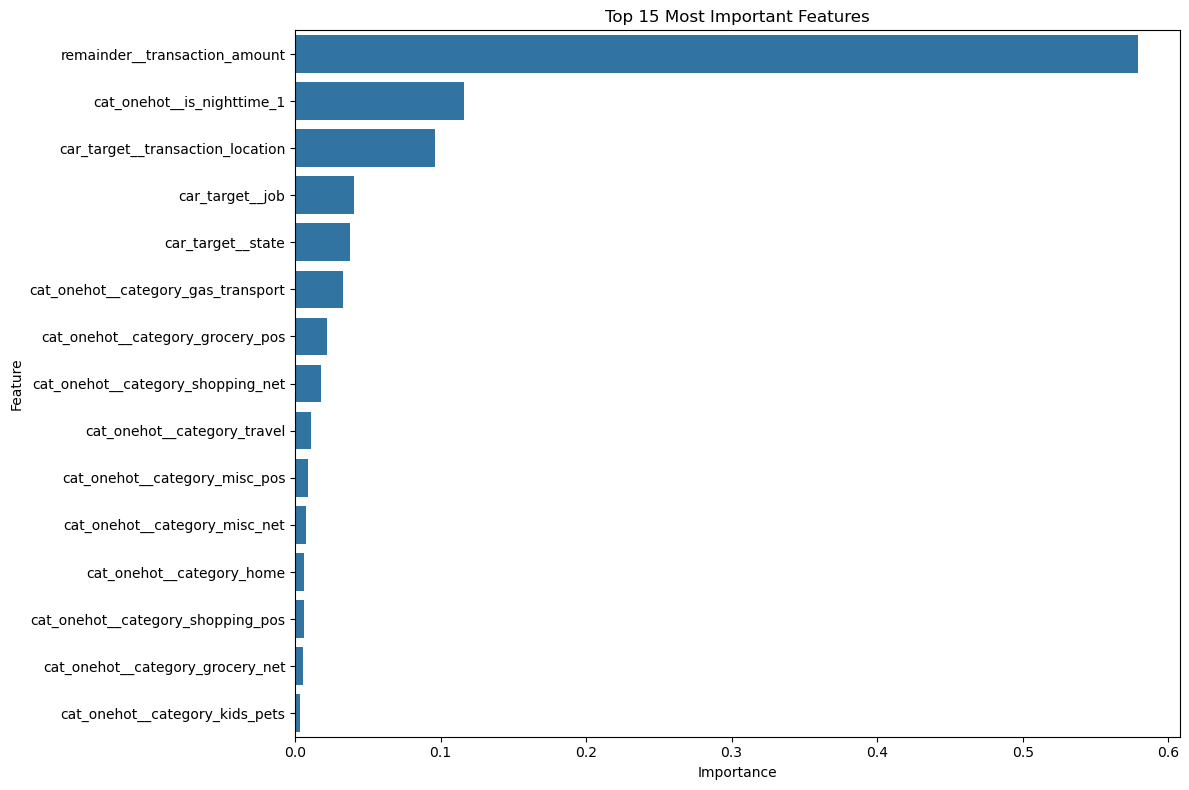

In [26]:
# Feature importance analysis 
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Get feature importance
feature_names = preprocessor.get_feature_names_out()
importance = rf.feature_importances_

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
})

# Sort by importance
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.show()

**Processing Pipeline Integration**

In [100]:
# Create final preprocessing pipeline 
final_pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("feature_selector", SelectFromModel(rf, threshold='median')),
    ("smote", smote)
])

# Pipeline for testing 
test_pipeline = Pipeline([
    ("preprocessor", final_pipeline.named_steps["preprocessor"]),
    ("feature_selector", final_pipeline.named_steps["feature_selector"])
])

# Apply final preprocessing and resampling to training data
X_train_final, y_train_final = final_pipeline.fit_resample(X_train, y_train)

# Transform test data (without fit)
X_test_final = test_pipeline.transform(X_test)

In [101]:
# Check the shape of transformed train and test data
print("Transformed training data shape:", X_train_final.shape)
print("Transformd testing data shape:", X_test_final.shape)

Transformed training data shape: (1621613, 9)
Transformd testing data shape: (370479, 9)


### **Model Training & Evaluation**

**Cross-Validation with Preprocessing Pipeline**

In [ ]:
# Define a function for cross-validation 
def cv_with_preprocessing(X, y, model, n_splits=5):
    # Use StratifiedKFold for imbalanced datasets
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Define evaluation metrics on minority class only
    metrics = {
        "precision": [],
        "recall": [],
        "f1": [],
        "pr-auc": []
    }

    # Iterate through each fold
    for train_idx, val_idx in cv.split(X, y):
        # Split the data for this fold (fixed typo "gold" -> "fold")
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # Create and fit preprocessing
        fold_preprocessor = Pipeline([
            ("preprocessor", preprocessor),
            ("feature_selector", SelectFromModel(rf, threshold='median'))
        ])
        
        fold_preprocessor.fit(X_train_fold, y_train_fold)   

        # Transform the data 
        X_train_fold_processed = fold_preprocessor.transform(X_train_fold)
        X_val_fold_processed = fold_preprocessor.transform(X_val_fold)

        # Apply SMOTE to training fold
        fold_smote = SMOTE(sampling_strategy=0.1, random_state=42)
        X_train_fold_resampled, y_train_fold_resampled = fold_smote.fit_resample(
            X_train_fold_processed, y_train_fold)     
        
        # Fit the model
        model.fit(X_train_fold_resampled, y_train_fold_resampled)

        # Make predictions  
        y_val_pred = model.predict(X_val_fold_processed)
        y_val_prob = model.predict_proba(X_val_fold_processed)[:, 1]

        # Evaluation metrics 
        metrics["precision"].append(precision_score(y_val_fold, y_val_pred, pos_label=1))
        metrics["recall"].append(recall_score(y_val_fold, y_val_pred, pos_label=1)) 
        metrics["f1"].append(f1_score(y_val_fold, y_val_pred, pos_label=1))
        metrics["pr-auc"].append(average_precision_score(y_val_fold, y_val_prob))

    # Calculate summary statistics for each metric
    results = {}
    for metric, values in metrics.items():
        results[f"{metric}_mean"] = np.mean(values)
        results[f"{metric}_std"] = np.std(values)
    
    return results

**Evaluation Metrics**

In [32]:
# Define a function to plot confusion matrix from the predictions
def metrics_score(y_test, y_pred):
    print("Classification Report of the Predictions:\n")
    print(classification_report(y_test, y_pred))
    print("="*50)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Generate custom labels with TP, FP, etc.
    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = [f"{value:0.0f}" for value in cm.flatten()]
    group_percentages = [f"{value:.2%}" for value in cm.flatten() / np.sum(cm)]
    labels = [f"{name}\nCount: {count}\n{percent}" for name, count, percent in zip(group_names, group_counts, group_percentages)]
    labels = np.array(labels).reshape(2, 2)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', 
                xticklabels=['Non-fraud', 'Fraud'], 
                yticklabels=['Non-fraud', 'Fraud'])
    
    plt.title("Confusion Matrix", fontsize=16)
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.show()

In [41]:
# Define a function to plot Precision-Recall Curve for Binary Classification
def plot_precision_recall(y_test, y_pred_proba, model):
    plt.figure(figsize=(8, 6))

    # Calculate precision, recall, and thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

    # Calculate the PR-AUC and Average Precision Score
    pr_auc = auc(recalls, precisions)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    # Plot Precision and Recall vs Threshold
    plt.plot(thresholds, precisions[:-1], label='Precision')
    plt.plot(thresholds, recalls[:-1], label='Recall')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"{model} Precision and Recall vs Threshold", fontsize=16)
    plt.legend()
    plt.grid(True)

    # Annotate PR AUC and Average Precision
    plt.annotate(f'PR AUC: {pr_auc:.3f}', xy=(0.5, 0.1), xycoords='axes fraction', fontsize=12)
    plt.annotate(f'Avg Precision: {avg_precision:.3f}', xy=(0.5, 0.05), xycoords='axes fraction', fontsize=12)

    plt.show()

### **Random Forest Classifier**

In [102]:
# Initialize the classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Fit the preprocessed and resampled data
rf.fit(X_train_final, y_train_final)

# Make predictions on the test set
y_pred = rf.predict(X_test_final)
y_pred_probab = rf.predict_proba(X_test_final)[:, 1]

Classification Report of the Predictions:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368549
           1       0.71      0.73      0.72      1930

    accuracy                           1.00    370479
   macro avg       0.85      0.86      0.86    370479
weighted avg       1.00      1.00      1.00    370479



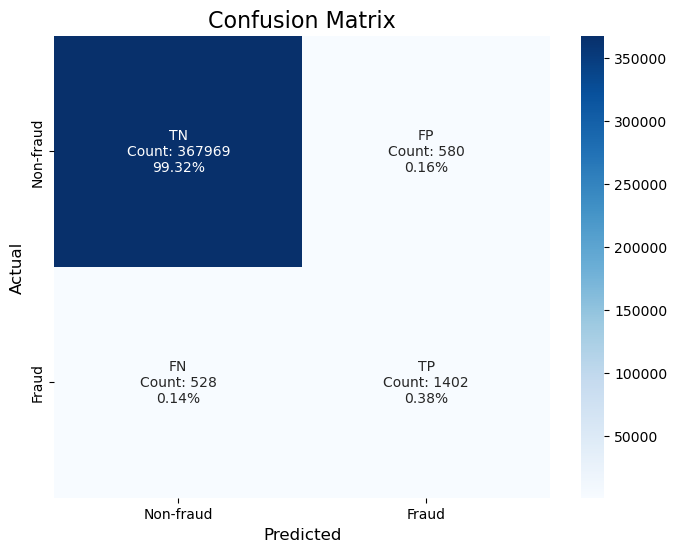

In [103]:
# Evaluate the model
metrics_score(y_test, y_pred)

**Findings**: We can see the macro average for F1 Score is 0.86 which is a not bad classifier. This value is high because the F1 Score for the majority class is 1 which makes the macro average higher as well.

- If we check the F1 Score for the minority class on fraud class, we can see that it is 0.72 with 0.71 for precision and 0.73 for recall. 

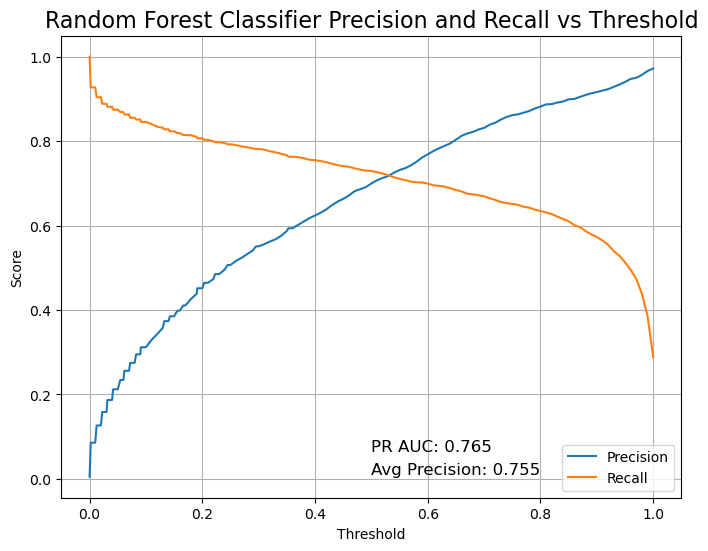

In [71]:
# Check the Precision-Recall Curve
plot_precision_recall(y_test, y_pred_probab, "Random Forest Classifier")

In [46]:
# Initialize the classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Apply Cross-Validation with SMOTE to assess model
cv_rf_results = cv_with_preprocessing(X_train, y_train, rf, n_splits=5)

# Check the results from CV
print("Cross-Validation Results:")
for metric, value in cv_rf_results.items():
    print(f"{metric}: {value:.4f}")

Cross-Validation Results:
precision_mean: 0.7056
precision_std: 0.0128
recall_mean: 0.7152
recall_std: 0.0056
f1_mean: 0.7103
f1_std: 0.0073
pr-auc_mean: 0.7416
pr-auc_std: 0.0021


**Findings**: Our cross-validation analysis reveals consistent performance across all evaluation metrics for the minority fraud class, with minimal variance between folds

- This indicates that our Random Forest Classifier is not overfitting, generating scores similar to each other across each fold during cross validation

    - F1 Score: Mean 0.710 (±0.007) demonstrates balanced optimization between precision and recall
    
    - Precision: Mean 0.706 (±0.013) shows good reliability in fraud predictions
    
    - Recall: Mean 0.715 (±0.006) indicates consistent detection of fraudulent transactions
    
    - PR-AUC: Mean 0.742 (±0.002) confirms stable ranking performance under class imbalance

- The remarkably low standard deviations across all metrics (all below 0.013) provide strong evidence that our Random Forest Classifier is not overfitting to the training data. This stability between cross-validation folds suggests the model has successfully captured generalizable fraud patterns rather than memorizing specific examples.

- The cross-validation performance metrics closely mirror those from the initial training phase, further confirming the model's robustness. This consistency across different data subsets indicates we've developed a reliable fraud detection system that should maintain its performance when deployed on new, unseen transaction data.

### **XGBoost**

In [47]:
# Initialize the classifier
xgb = XGBClassifier(random_state=42, n_jobs=-1)

# Fit the preprocessed and resampled data
xgb.fit(X_train_final, y_train_final)

# Make predictions on the test set
y_pred = xgb.predict(X_test_final)
y_pred_probab = xgb.predict_proba(X_test_final)[:, 1]

Classification Report of the Predictions:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368549
           1       0.72      0.75      0.74      1930

    accuracy                           1.00    370479
   macro avg       0.86      0.87      0.87    370479
weighted avg       1.00      1.00      1.00    370479



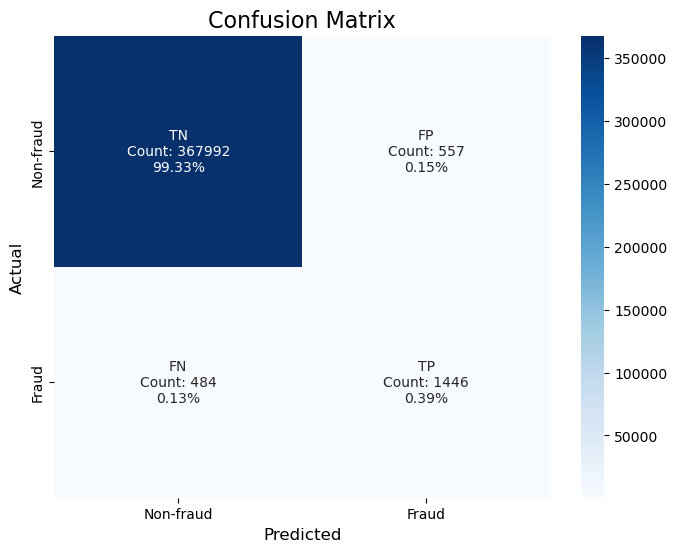

In [48]:
# Evaluate the model
metrics_score(y_test, y_pred)

**Findings**: We can see an increase in the evaluation metric scores for XGBoost Classifier from F1 Score of 0.72 to 0.74. 

- There is a decrease in the False Negative and False Positive Predictions.

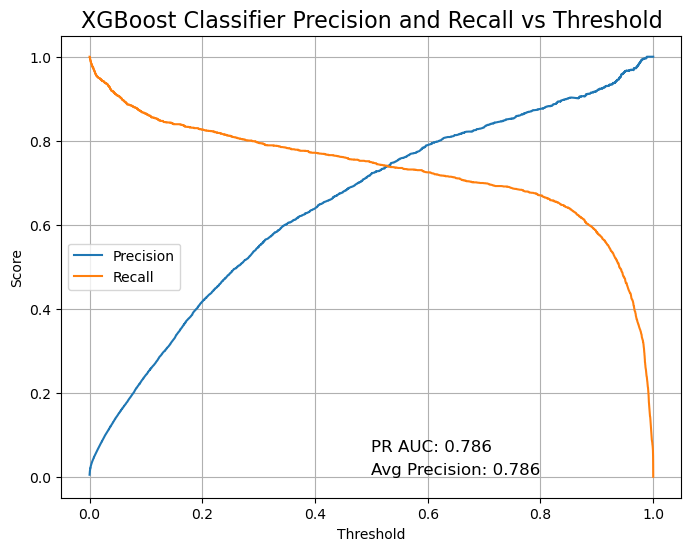

In [49]:
# Check the Precision-Recall Curve
plot_precision_recall(y_test, y_pred_probab, "XGBoost Classifier")

In [50]:
# Initialize the classifier
xgb = XGBClassifier(random_state=42, n_jobs=-1)

# Apply Cross-Validation with SMOTE to assess model
cv_rf_results = cv_with_preprocessing(X_train, y_train, xgb, n_splits=5)

# Check the results from CV
print("Cross-Validation Results:")
for metric, value in cv_rf_results.items():
    print(f"{metric}: {value:.4f}")

Cross-Validation Results:
precision_mean: 0.7265
precision_std: 0.0091
recall_mean: 0.7331
recall_std: 0.0055
f1_mean: 0.7297
f1_std: 0.0051
pr-auc_mean: 0.7724
pr-auc_std: 0.0041


**Findings**: Our comprehensive cross-validation assessment reveals exceptional performance consistency for the XGBoost classifier across all evaluation folds.

- Robust Metric Stability: The model demonstrates remarkable consistency with low variance across all key metrics:

    - F1 Score: 0.730 (±0.005) - only 0.7% variance across folds

    - Precision: 0.727 (±0.009) - maintaining consistent fraud identification confidence

    - Recall: 0.733 (±0.006) - steady fraud detection capability

    - PR-AUC: 0.772 (±0.004) - stable ranking performance despite severe class imbalance (0.42%)


### **Hyperparameter Tuning** 

In [56]:
# Define parameters for Grid Search
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_child_weight': [3, 5],
}

# Prioritize F1 score for minority class
scoring = make_scorer(f1_score, pos_label=1)

# Create the Imbalanced-Learn pipeline 
imb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(rf, threshold='median')),
    ('smote', SMOTE(sampling_strategy=0.1, random_state=42)),
    ('classifier', XGBClassifier(eval_metric='aucpr', random_state=42))
])

# Define cross-validation strategy - use StratifiedKFold for imbalanced data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with the imbalanced-learn pipeline
grid_search = GridSearchCV(
    estimator=imb_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Fit GridSearchCV on the original training data (not pre-resampled)
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_estimators=100; total time= 4.1min
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_estimators=100; total time= 4.1min
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_estimators=100; total time= 4.2min
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_estimators=100; total time= 4.2min
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_estimators=100; total time= 4.2min
[CV] END classifier__learning_rate=0.05, classifier__max_depth=3, classifier__min_child_weight=3, classifier__n_estimators=200; total time= 4.3min
[CV] END classifier__learning_rate=0.05, classifier__max

Classification Report of the Predictions:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368549
           1       0.70      0.75      0.73      1930

    accuracy                           1.00    370479
   macro avg       0.85      0.87      0.86    370479
weighted avg       1.00      1.00      1.00    370479



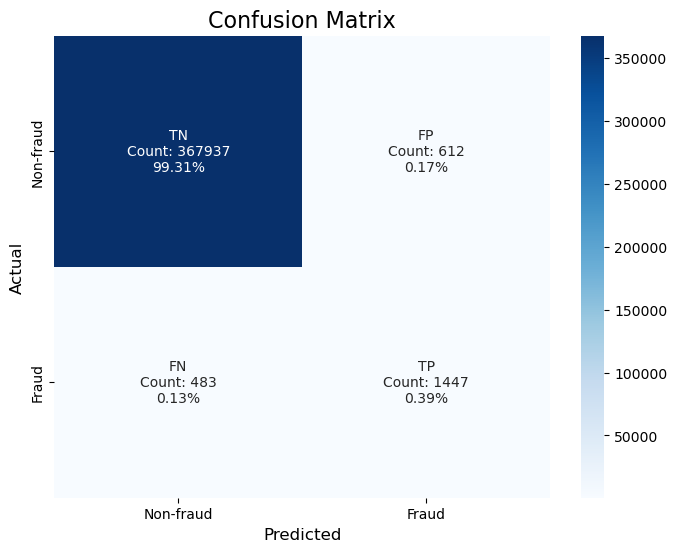

In [58]:
# Get the best model
best_xgb_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_xgb_model.predict(X_test)
y_pred_probab = best_xgb_model.predict_proba(X_test)[:, 1]

# Get the metrics score
metrics_score(y_test, y_pred)

**Findings**: After tuning the XGBoost Classifier on the over sampling dataset with SMOTE with a focus score on F1 Score for Minority Class, we have found that:

- There is a drop of 0.01 in F1 Score for Tuned Classifier than Non-tuned Classifier which is 0.73 and 0.74 respectively. 

- In this case, we are going to use the non-tuned moodel with the higher F1 Score of 0,74 rather than the tuned model. 

**Key Considerations**

1. Performance Metric Priority: F1 score is the most relevant metric for fraud detection as it balances precision and recall, directly impacting both financial loss prevention and operational efficiency.

2. Statistical Significance: The 0.01 difference (0.74 vs 0.73) represents:

    - Potentially dozens of additional correctly identified fraud cases in large transaction volumes
    
    - Overfitting Assessment: The non-tuned model shows higher test performance without signs of overfitting, suggesting it has better generalization capabilities for this specific data distribution.

3. Model Simplicity: The non-tuned model likely has fewer parameters and a simpler structure, making it:

    - Easier to deploy
    
    - More interpretable
    
    - Potentially more computationally efficient
    
    - Business Impact: In fraud detection, even marginal improvements in F1 score translate to significant financial impacts by:

In [ ]:
# Save the best model
joblib.dump(xgb, 'xgb_model.pkl', compress=3)

# Save preprocessor pipeline
joblib.dump(test_pipeline, 'preprocessor_pipeline.pkl', compress=3)

['preprocessor_pipeline.pkl']